In [1]:
!pip install inference inference-gpu supervision opencv-python
!pip install git+https://github.com/roboflow/sports.git


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/roboflow/sports.git to c:\users\isss1\appdata\local\temp\pip-req-build-wgo7inuc
  Resolved https://github.com/roboflow/sports.git to commit 06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/sports.git 'C:\Users\isss1\AppData\Local\Temp\pip-req-build-wgo7inuc'

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install torch


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. Training on GPU!")
else:
    print("CUDA is not available. Training on CPU.")

CUDA is not available. Training on CPU.


In [28]:
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch
import supervision as sv
from inference import get_model
import numpy as np
import cv2

BALL_CLASS_ID = 0
GOALKEEPER_CLASS_ID = 1
PLAYER_CLASS_ID = 2
REFEREE_CLASS_ID = 3

SOCCER_PITCH_CONFIG = SoccerPitchConfiguration()
PITCH_CONFIDENCE_LEVEL = 0.7
KEYPOINT_CONFIDENCE_LEVEL = 0.6
OBJECT_DETECTION_MODEL_NAME = "soccer-computer-vision-acffy/3"

# TODO: Change this to my model when I revise it, and include 36 keypoints
KEYPOINT_DETECTION_MODEL_NAME = "football-field-detection-f07vi/15"

# Setting the models as global variables so that they're not repeatedly called
keypointModel = get_model(model_id=KEYPOINT_DETECTION_MODEL_NAME)
objectModel = get_model(model_id=OBJECT_DETECTION_MODEL_NAME)

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError(
                "Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError(
                f"Source and target points must be 2D coordinates. They are currently {source.shape} and {target.shape}.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError(
                "Homography matrix could not be calculated.")

    def transformPoints(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        
        return points.reshape(-1, 2).astype(np.float32)

def getObjectDetections(frame, index):
    result = objectModel.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    return detections

# Uses a keypoint detection model to return pitch keypoints
def getPitchKeypoints(image):
    result = keypointModel.infer(image, confidence=PITCH_CONFIDENCE_LEVEL)[0]    
    keypoints = sv.KeyPoints.from_inference(result)
    
    return keypoints

def getKeypointsFilter(keypoints):
    filter = keypoints.confidence > KEYPOINT_CONFIDENCE_LEVEL
    
    return filter
    
def getFilteredKeypoints(keypoints, filter):
    xy = keypoints.xy[filter]
    confidence = keypoints.confidence[filter]
    filteredKeypoints = sv.KeyPoints(xy=xy[np.newaxis, ...], confidence=confidence[np.newaxis, ...])
    
    return filteredKeypoints

# Takes a set of actual and target keypoints, compares them and returns the Homography matrix
def getTransformer(source, targets):
    return ViewTransformer(source=source, target=targets)

def getObjectClassDetections(detections, classId):
    return detections[detections.class_id == classId]

def getCoordsFromDetections(detections):
    return detections.get_anchors_coordinates(anchor=sv.Position.CENTER)

def getPitchTransformedCoords(detections, transformer):
    return transformer.transformPoints(points=detections.get_anchors_coordinates(anchor=sv.Position.CENTER))

def getClassCoords(detections, transformer, classId):
    classDetections = getObjectClassDetections(detections, classId)
    classCoords = getPitchTransformedCoords(classDetections, transformer)
    
    return classCoords

def getAnnotatedImageWithSpecifiedCoords(image, coords, faceColor, edgeColor):
    return draw_points_on_pitch(
        config=SOCCER_PITCH_CONFIG,
        xy=coords,
        face_color=faceColor,
        edge_color=edgeColor,
        radius=8,
        thickness=1,
        pitch=image
    )

# Takes object detections and annotates the footage
# Keypoint detections are optional, and will not be rendered if they're not passed
def getAnnotatedFootage(image, objectDetections, keypointDetections=None):
    # Output detections image, with keypoints and object detection
    boundingBoxAnnotator = sv.BoxAnnotator()
    labelAnnotator = sv.LabelAnnotator()
    
    objectLabels = [ f"{class_name} {confidence:.2f}" for class_name, confidence in zip(objectDetections['class_name'], objectDetections.confidence) ]
    
    annotagedImage = boundingBoxAnnotator.annotate(scene=image, detections=objectDetections)
    annotagedImage = labelAnnotator.annotate(scene=annotagedImage, detections=objectDetections, labels=objectLabels)

    # Plotting all available keypoints, but showing their confidence levels
    if keypointDetections:
        keypointAnnotator = sv.VertexAnnotator(radius=12, color=sv.Color.GREEN)
        annotagedImage = keypointAnnotator.annotate(annotagedImage, keypointDetections)
    
    return annotagedImage


def getAnnotatedPitch(objectDetections, transformer):
    # Transforming detections for the homography matrix
    ballCoords = getClassCoords(objectDetections, transformer, BALL_CLASS_ID)
    goalkeeperCoords = getClassCoords(objectDetections, transformer, GOALKEEPER_CLASS_ID)
    playerCoords = getClassCoords(objectDetections, transformer, PLAYER_CLASS_ID)
    refereeCoords = getClassCoords(objectDetections, transformer, REFEREE_CLASS_ID)
    
    pitchImage = draw_pitch(SOCCER_PITCH_CONFIG)
    
    annotatedPitch = getAnnotatedImageWithSpecifiedCoords(pitchImage, ballCoords, sv.Color.WHITE, sv.Color.BLACK)
    annotatedPitch = getAnnotatedImageWithSpecifiedCoords(annotatedPitch, goalkeeperCoords, sv.Color.GREEN, sv.Color.BLACK,)
    annotatedPitch = getAnnotatedImageWithSpecifiedCoords(annotatedPitch, playerCoords, sv.Color.BLUE, sv.Color.BLACK)
    annotatedPitch = getAnnotatedImageWithSpecifiedCoords(annotatedPitch, refereeCoords, sv.Color.YELLOW, sv.Color.BLACK)
    
    return annotatedPitch

def annotatedFootageCallback(scene, index):
    objectDetections = getObjectDetections(scene, None)
    
    return getAnnotatedFootage(scene, objectDetections)

def annotatedPitchCallback(scene, index):
    keypoints = getPitchKeypoints(scene)
    filter = getKeypointsFilter(keypoints)
    filteredKeypoints = getFilteredKeypoints(keypoints, filter)
    objectDetections = getObjectDetections(scene, None)
    transformer = getTransformer(filteredKeypoints.xy[0],  np.array(SOCCER_PITCH_CONFIG.vertices)[filter[0]])

    return getAnnotatedPitch(objectDetections, transformer)


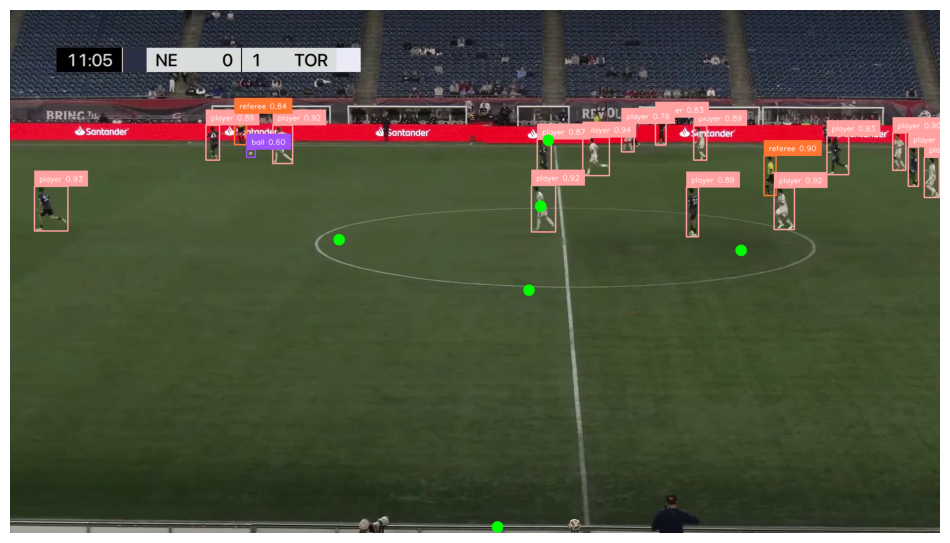

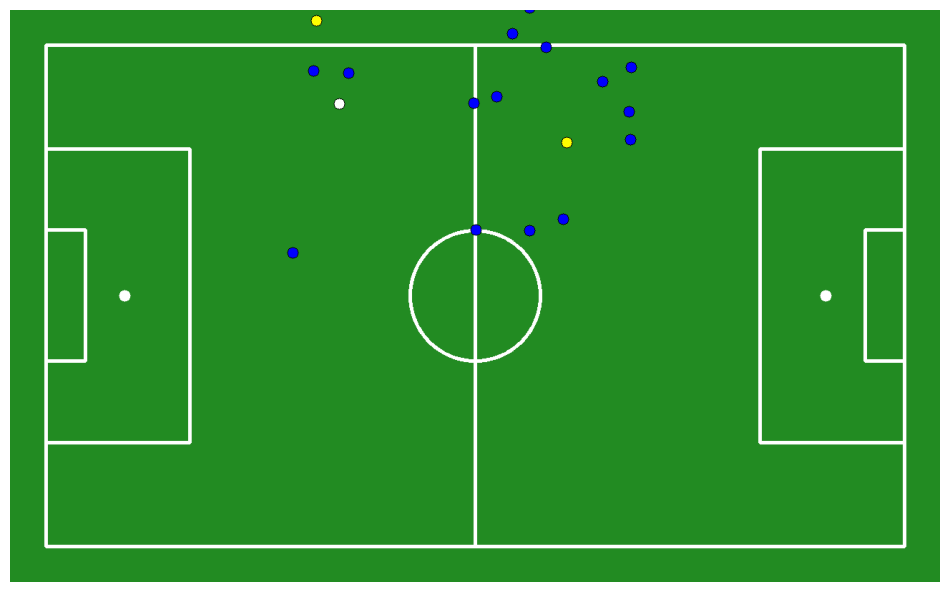

In [29]:
# Perspective transformation
fileName = "images-pitch/frame85.jpg"
image = cv2.imread(fileName)
keypoints = getPitchKeypoints(image)
filter = getKeypointsFilter(keypoints)
filteredKeypoints = getFilteredKeypoints(keypoints, filter)
objectDetections = getObjectDetections(image, None)
transformer = getTransformer(filteredKeypoints.xy[0],  np.array(SOCCER_PITCH_CONFIG.vertices)[filter[0]])

annotatedFootageImage = getAnnotatedFootage(image, objectDetections, filteredKeypoints)
annotatedPitchImage = getAnnotatedPitch(objectDetections, transformer)

sv.plot_image(annotatedFootageImage)
sv.plot_image(annotatedPitchImage)

In [11]:
TEST_CLIP_PATH = "example.mp4"

# print("Creating annotated footage video...")
# sv.process_video(source_path=TEST_CLIP_PATH, target_path="annotated-footage/annotated-footage.mp4", callback=annotatedFootageCallback)
# print("Finished creating video.")
print("Creating annotated tactical map vieo...")
sv.process_video(source_path=TEST_CLIP_PATH, target_path="annotated-footage/annotated-tactical-map.mp4", callback=annotatedPitchCallback)
print("Finished creating video.")

Creating annotated tactical map vieo...
[[6784.303  4570.182 ]
 [7162.9165 5835.3374]
 [6614.335  6312.152 ]
 [7107.0293 3932.5125]
 [8114.3423 4450.754 ]
 [6045.9775 3084.0955]
 [4674.262  2212.1882]
 [6815.5874 1237.1757]
 [5814.6387 3664.279 ]
 [8048.0903 2819.987 ]
 [4171.8823 1877.5487]
 [5010.5083 4180.6772]
 [7734.306  3594.7185]
 [5449.6914 2980.148 ]
 [5036.4233 5203.8184]
 [5639.4775  687.3207]
 [5394.6714 3329.928 ]]
[[7173.3867 5832.0894]
 [6774.05   4564.9893]
 [6607.961  6302.1147]
 [4709.358  2225.6677]
 [6817.64   1251.7122]
 [8138.591  4444.333 ]
 [7134.9287 3904.4988]
 [8062.387  2804.847 ]
 [6045.2134 3104.4888]
 [4205.9893 1906.0687]
 [7774.3374 3604.384 ]
 [5482.928  3186.1067]
 [5832.511  3647.578 ]
 [5034.504  4176.0767]
 [5635.5938  705.4178]
 [5046.305  5162.119 ]]
[[7087.6533  5515.7505 ]
 [6083.043   3109.0476 ]
 [6603.411   6107.964  ]
 [7071.1704  3725.2046 ]
 [4778.963   2321.2368 ]
 [6717.8945  4394.6094 ]
 [5113.573   4289.1064 ]
 [5109.8047  5278.033  ]

In [35]:
import supervision as sv
from IPython.display import clear_output
import time

# Testing the 2D view with a run through of the images

for frame in sv.get_video_frames_generator(source_path='clip_9.mp4'):
    keypoints = getPitchKeypoints(frame)
    
    print(type(keypoints))
    
    filter = getKeypointsFilter(keypoints)
    filteredKeypoints = getFilteredKeypoints(keypoints, filter)
    objectDetections = getObjectDetections(frame, None)
    transformer = getTransformer(filteredKeypoints.xy[0],  np.array(SOCCER_PITCH_CONFIG.vertices)[filter[0]])

    annotatedFootageImage = getAnnotatedFootage(frame, objectDetections, filteredKeypoints)
    annotatedPitchImage = getAnnotatedPitch(objectDetections, transformer)
    
    clear_output(wait=True)
    sv.plot_image(annotatedFootageImage)
    sv.plot_image(annotatedPitchImage)
    time.sleep(1)
    

KeyboardInterrupt: 